In [36]:
#import packages and find the path to the database you would like to use!
import sqlite3
import pandas as pd

db = '../../Github_AMD_Project/etl/data/database/patient_education.db'

In [37]:
#get the tables associated with the database
with sqlite3.connect(db) as conn:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type = 'table';", conn)
tables

,name
0,patients
1,module_results
2,sqlite_sequence


In [38]:
#connect to database created with etl pipeline using sqlite3
with sqlite3.connect(db) as conn:
    print(pd.read_sql_query('SELECT name FROM sqlite_master WHERE type = "table";', conn))
    print(pd.read_sql_query('PRAGMA table_info(patients)', conn))
    print(pd.read_sql_query('SELECT COUNT(*) FROM patients;', conn))
    print(pd.read_sql_query('SELECT COUNT(*) FROM module_results;', conn))

              name
0         patients
1   module_results
2  sqlite_sequence
   cid        name  type  notnull dflt_value  pk
0    0  patient_id  TEXT        0       None   1
1    1         age   INT        0       None   0
2    2         sex  TEXT        0       None   0
3    3        va_l  REAL        0       None   0
4    4        va_r  REAL        0       None   0
5    5     disease  TEXT        0       None   0
   COUNT(*)
0        50
   COUNT(*)
0       100


In [39]:
#move data to pandas
with sqlite3.connect(db) as conn:
    patients = pd.read_sql_query('SELECT* FROM patients;', conn)
    modules = pd.read_sql_query('SELECT* FROM module_results;', conn)

In [40]:
#calculate average improvement by module
modules['delta'] = modules['post_score'] - modules['pre_score']
avg_delta_by_module = modules.groupby('module_number')['delta'].mean()

In [41]:
avg_delta_by_module

module_number
1    0.62
2    0.74
Name: delta, dtype: float64

In [42]:
#merge modules table and patients tables
merged = modules.merge(patients, on = 'patient_id', how = 'left')

In [43]:
#average score per module
avg_scores = merged.groupby('module_number')[['pre_score','post_score']].mean()
avg_scores

,pre_score,post_score
module_number,,
1,2.82,3.44
2,2.52,3.26


In [44]:
#drop null values for the modules we did not collect quiz scores on
avg = avg_scores.dropna()
avg

,pre_score,post_score
module_number,,
1,2.82,3.44
2,2.52,3.26


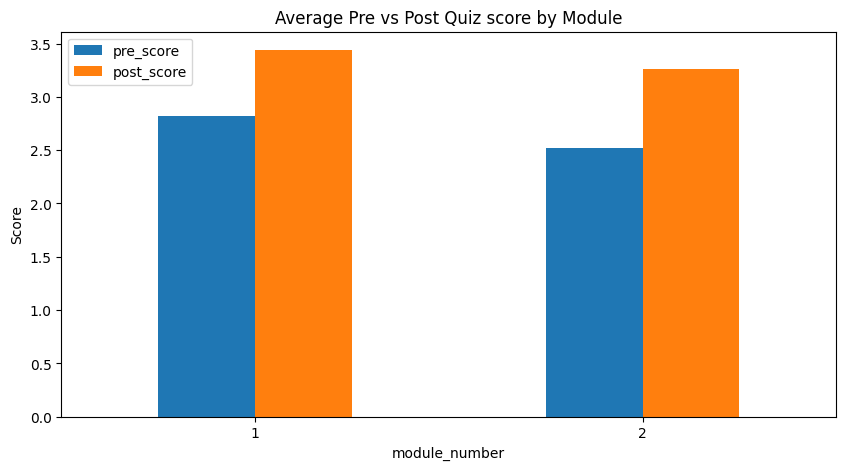

In [45]:
#display pre vs post average score per module
import matplotlib.pyplot as plt

avg.plot(kind = 'bar', figsize = (10,5))

plt.title('Average Pre vs Post Quiz score by Module')
plt.ylabel('Score')
plt.xticks(rotation = 0)
plt.show()

As can easily be seen, every module increased post module! While some modules improved much more than others. This can be due to several features such as:
* general information that was already well known in the early modules
* better question formation after patient feedback
* more buy in from patients after the first two modules

In [46]:
#change in scores per module
merged['delta'] = merged['post_score']-merged['pre_score']
avg_delta  = merged.groupby('module_number')['delta'].mean()
avg_delta = avg_delta.dropna()

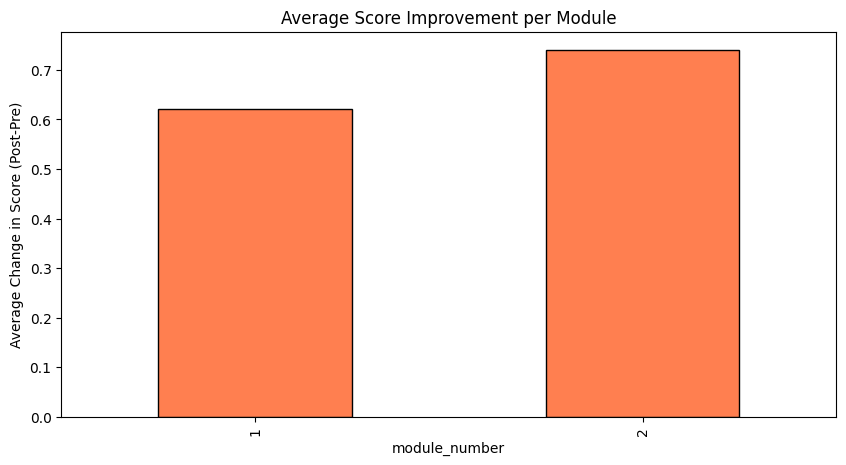

In [47]:
avg_delta.plot(kind = 'bar', figsize = (10,5), edgecolor = 'black', color = 'coral')
plt.title('Average Score Improvement per Module')
plt.ylabel('Average Change in Score (Post-Pre)')
plt.show()

## Demographic Splits

In [48]:
merged = modules.merge(patients, on = 'patient_id', how = 'left')

#overall average feedback scores
overall_feedback = merged['feedback_score'].mean()
print(f'Overall average feedback score: {overall_feedback:.2f}')

Overall average feedback score: 1.95


Overall the project showed just under a positive feedback score but higher than a neutral score.

In [49]:
feedback_by_sex = merged.groupby('sex')['feedback_score'].mean()
print(feedback_by_sex)

sex
F    2.200000
M    2.451613
Name: feedback_score, dtype: float64


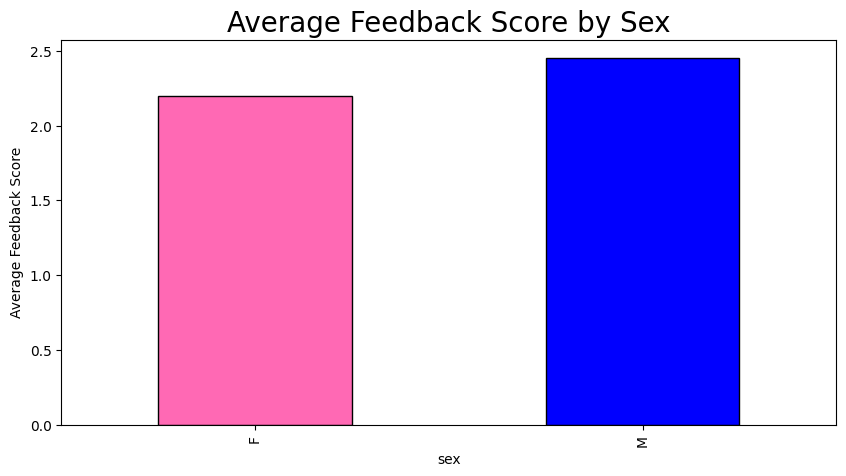

In [50]:
feedback_by_sex.plot(kind = 'bar', color = ['hotpink','blue'],edgecolor = 'k', figsize = (10,5))
plt.title("Average Feedback Score by Sex", fontsize = 20)
plt.ylabel("Average Feedback Score")
plt.show()

Females gave more positive scores than men. This is not surprising with how the patients acted during visits. The female patients tended to ask more questions, and be more enthusiastic about learning the material. They also showed more competitiveness with quiz score improvements in general.

In [51]:
feedback_by_disease = merged.groupby('disease')['feedback_score'].mean()
print(feedback_by_disease)

disease
dry    2.068966
wet    2.727273
Name: feedback_score, dtype: float64


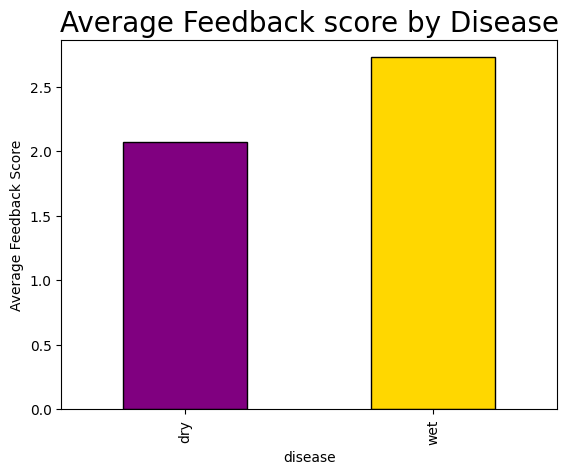

In [52]:
feedback_by_disease.plot(kind = 'bar', color = ['purple','gold'], edgecolor = 'k')
plt.title('Average Feedback score by Disease', fontsize = 20)
plt.ylabel('Average Feedback Score')
plt.show()

This information is interesting. There was a little more enthusiasm toward the project from the patients that came in more often than the ones that come in roughly every 6 months - 1 year. Whether this was because there was more data, patients enjoyed the change in clinic flow when they come in more ofter, or the enjoyed learning ways to potentially help their vision because of worse disease type are all potential reasonings!

In [53]:
def snellen_groups(va):
    if pd.isna(va): return 'Unknown'
    va = str(va).strip()
    if va in ['20/20','20/25']: return 'Good'
    if va in ['20/32','20/30','20/40','20/50']: return 'Okay'
    elif va in ['20/40','20/50','20/63']: return 'Bad'
    else: return 'Very_Poor'
merged['va_l_group'] = merged['va_l'].apply(snellen_groups)
merged['va_r_group'] = merged['va_r'].apply(snellen_groups)

In [54]:
order = {'Good':4, 'Okay':3,'Bad':2,'Very_Poor':1, 'Unknown':0}

def best_va(row):
    left_score = order.get(row['va_l_group'],0)
    right_score = order.get(row['va_r_group'],0)
    if left_score>=right_score:
        return row['va_l_group']
    else:
        return row['va_r_group']

In [55]:
merged['best_va'] = merged.apply(best_va, axis = 1)

In [56]:
merged[['va_l','va_r','va_l_group','va_r_group','best_va']]

,va_l,va_r,va_l_group,va_r_group,best_va
0,lp,20/250,Very_Poor,Very_Poor,Very_Poor
1,20/400,20/25,Very_Poor,Good,Good
2,lp,20/30,Very_Poor,Okay,Okay
3,20/20,20/80,Good,Very_Poor,Good
4,20/40,20/50,Okay,Okay,Okay
...,...,...,...,...,...
95,NaN,NaN,Unknown,Unknown,Unknown
96,NaN,NaN,Unknown,Unknown,Unknown
97,NaN,NaN,Unknown,Unknown,Unknown
98,NaN,NaN,Unknown,Unknown,Unknown


In [57]:
feedback_by_best_va = merged.groupby('best_va')['feedback_score'].mean().sort_index()

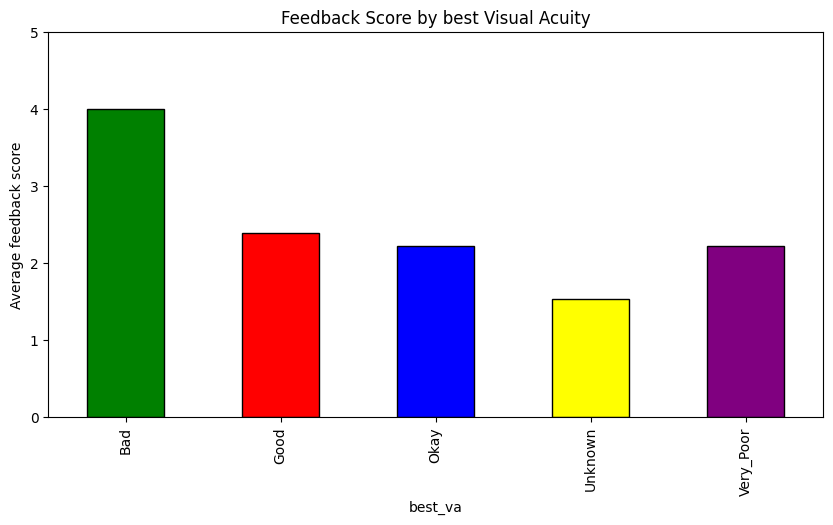

In [58]:
feedback_by_best_va.plot(kind = 'bar', color = ['green','red','blue','yellow','purple'], edgecolor = 'k', figsize = (10,5))
plt.title('Feedback Score by best Visual Acuity')
plt.ylabel('Average feedback score')
plt.ylim(0,5)
plt.show()

All of the feedback tended to be consistent between patient's visual acuity!

## Feedback Analysis

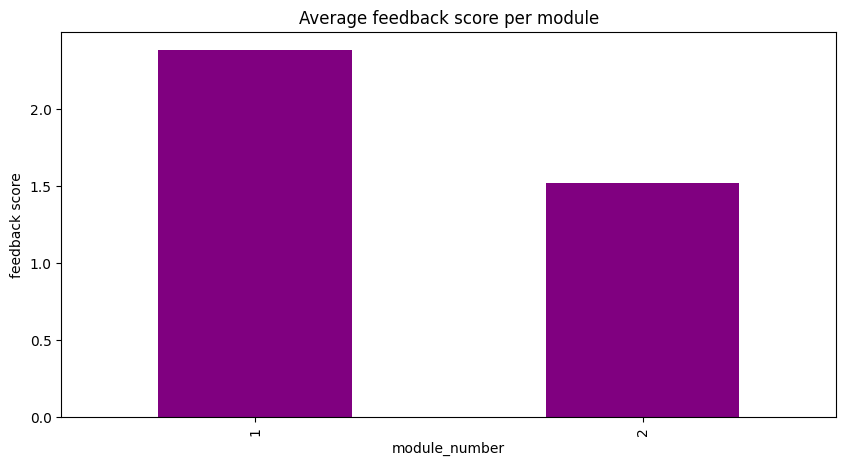

In [59]:
feedback_avg = merged.groupby('module_number')['feedback_score'].mean()
feedback_avg.plot(kind = 'bar', color = 'purple', figsize = (10,5))
plt.title('Average feedback score per module')
plt.ylabel('feedback score')
plt.show()

In [60]:
feedback_text = merged['feedback'].dropna()
print(feedback_text.head(10))

0              Would recommend to others
1       Pace was good, avatars were fine
2      Neutral toward avatars, good info
3      Neutral toward avatars, good info
4          Videos were clear and helpful
5              Would recommend to others
6          Videos were clear and helpful
7      Neutral toward avatars, good info
8    Very informative and easy to follow
9               Helpful for new patients
Name: feedback, dtype: object


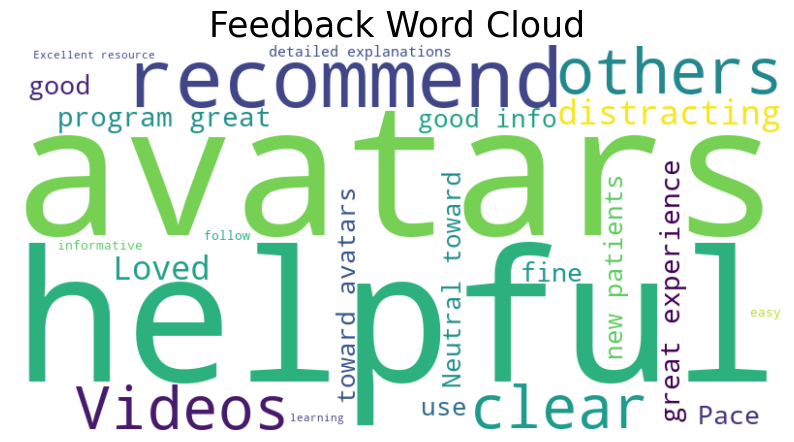

In [61]:
#word cloud
from wordcloud import WordCloud

text = ' '.join(feedback_text)
wordcloud = WordCloud(width = 800, height = 400, background_color = 'white').generate(text)
plt.figure(figsize = (10,6))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Feedback Word Cloud', fontsize = 25)
plt.show()

### The most common words seen in the feedback were good, fine, and different forms of informative (information, informative. info).

In [64]:
from textblob import TextBlob


merged['sentiment'] = feedback_text.apply(lambda x: TextBlob(str(x)).sentiment.polarity)
print(merged[['feedback', 'sentiment']])

                               feedback  sentiment
0             Would recommend to others   0.000000
1      Pace was good, avatars were fine   0.558333
2     Neutral toward avatars, good info   0.700000
3     Neutral toward avatars, good info   0.700000
4         Videos were clear and helpful   0.100000
..                                  ...        ...
95             Helpful for new patients   0.136364
96     Pace was good, avatars were fine   0.558333
97             Helpful for new patients   0.136364
98  Loved the program, great experience   0.750000
99        Videos were clear and helpful   0.100000

[100 rows x 2 columns]


In [65]:
print(merged['sentiment'].mean())

0.3392727272727272


### Using textblob, we see that their scoring is quite different and that the patients had a neutral tone to their feedback. This is a great sign for the use of newer technology such as avatars to educate patients over the age of 50, and the visually impaired.